# Lion-Q-VQE
## Our teams take on implmenting a VQE and using it to optimize a Financial Portfolio

### Imports

In [41]:
from qiskit.circuit.library import TwoLocal, ZZFeatureMap, EfficientSU2
from qiskit.result import QuasiDistribution
from qiskit.primitives import StatevectorSampler, StatevectorEstimator

from qiskit_algorithms.gradients import FiniteDiffEstimatorGradient, SPSAEstimatorGradient, LinCombEstimatorGradient, ParamShiftEstimatorGradient, ParamShiftSamplerGradient, QFI, DerivativeType, LinCombQGT
from qiskit_optimization.translators import from_docplex_mp
from qiskit_algorithms.optimizers import COBYLA
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import RandomDataProvider
from qiskit_optimization.algorithms import MinimumEigenOptimizer

import numpy as np
import matplotlib.pyplot as plt
import datetime

### Global Variables

In [42]:
# set number of assets which is equal to number of qubits
num_assets = 25
seed = 479

# Generate expected return and covariance matrix from (random) time-series
stocks = [("TICKER%s" % i) for i in range(num_assets)]
data = RandomDataProvider(
    tickers=stocks,
    start=datetime.datetime(2023, 1, 1),
    end=datetime.datetime(2023, 1, 30),
    seed=seed,
)

print(data)

In [43]:
data.run()
ev = data.get_period_return_mean_vector() # Initial state to optimize over
covariance = data.get_period_return_covariance_matrix() # Hamiltonian Matrix

risk_factor = 0.5  # set risk factor
budget = 20  # set budget
#penalty = num_assets  # set parameter to scale the budget penalty term

qp = PortfolioOptimization(expected_returns=ev, covariances=covariance, risk_factor=risk_factor, budget=budget).to_quadratic_program()

In [44]:
# Use StatevectorEstimator instead of the deprecated Estimator
estimator = StatevectorEstimator()
optimizer = COBYLA()

### Ansatz Implementation Comparison and Analysis

In [45]:
# 3 common quantum circuits to use for ansatz with linear entanglement
ZZ = ZZFeatureMap(feature_dimension=num_assets, entanglement='linear', reps=1)
SU2 = EfficientSU2(num_assets, entanglement='linear', reps=1)
TwoL = TwoLocal(num_assets, entanglement='linear', reps=1)
linear_ansatz = [ZZ, SU2, TwoL]

# 3 common quantum circuits to use for ansatz with cyclic entanglement
ZZ = ZZFeatureMap(feature_dimension=num_assets, entanglement='cyclic', reps=1)
SU2 = EfficientSU2(num_assets, entanglement='cyclic', reps=1)
TwoL = TwoLocal(num_assets, entanglement='cyclic', reps=1)
cyclic_ansatz = [ZZ, SU2, TwoL]

# 3 common quantum circuits to use for ansatz with full entanglement
ZZ = ZZFeatureMap(feature_dimension=num_assets, entanglement='full', reps=1)
SU2 = EfficientSU2(num_assets, entanglement='full', reps=1)
TwoL = TwoLocal(num_assets, entanglement='full', reps=1)
full_ansatz = [ZZ, SU2, TwoL]

# master list for ansatz circuits shape is 3 x 3
ansatz_list = [linear_ansatz, cyclic_ansatz, full_ansatz]

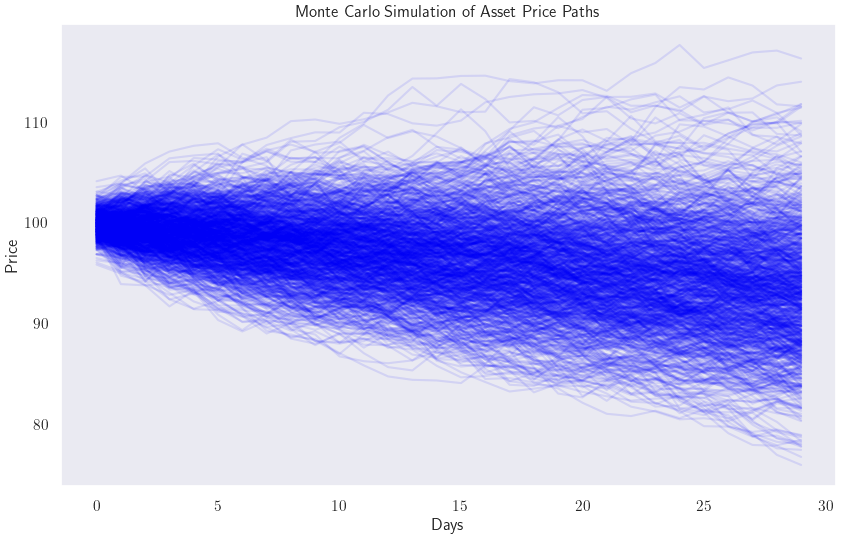

TICKER0: $93.16
TICKER1: $100.90
TICKER2: $91.89
TICKER3: $96.80
TICKER4: $126.67
TICKER5: $95.15
TICKER6: $80157193.41
TICKER7: $90.94
TICKER8: $97.53
TICKER9: $326.85
TICKER10: $97.80
TICKER11: $99.79
TICKER12: $101.30
TICKER13: $107.90
TICKER14: $101.70
TICKER15: $103.55
TICKER16: $95.79
TICKER17: $91.78
TICKER18: $116.63
TICKER19: $28.53
TICKER20: $180.79
TICKER21: $106.52
TICKER22: $94.01
TICKER23: $133.24
TICKER24: $94.65


In [46]:
# Parameters
num_simulations = 1000
num_days = 30

# Monte Carlo Simulation
simulated_price_paths = np.zeros((num_simulations, num_days, num_assets))

# Initial asset prices (for simplicity, let's assume they all start at $100)
initial_prices = 100 * np.ones(num_assets)

for sim in range(num_simulations):
    daily_returns = np.random.multivariate_normal(ev, covariance, num_days)
    price_paths = initial_prices * np.exp(np.cumsum(daily_returns, axis=0))  # Cumulative product for prices
    simulated_price_paths[sim] = price_paths

# Calculate expected portfolio value at the end of the simulation period
final_prices = simulated_price_paths[:, -1, :]
portfolio_value = np.mean(final_prices, axis=0)

# Plotting the simulated price paths for the first asset
plt.figure(figsize=(10, 6))
for i in range(num_simulations):
    plt.plot(simulated_price_paths[i, :, 0], color='blue', alpha=0.1)  # Plot first asset price path
plt.title("Monte Carlo Simulation of Asset Price Paths")
plt.xlabel("Days")
plt.ylabel("Price")
plt.grid()
plt.show()

# Print final portfolio values
for i, ticker in enumerate(stocks):
    print(f"{ticker}: ${portfolio_value[i]:.2f}")


In [55]:
# Portfolio optimization
best_portfolio = None
best_return = -np.inf

# Lists to store results for plotting
returns_list = []
risks_list = []

# Iterate over random portfolio allocations
for _ in range(10000):  # Try 10,000 random allocations
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)  # Normalize weights to sum to 1
    scaled_weights = weights * budget # Scale weights to fit the budget

    # Calculate portfolio return and risk
    portfolio_return = np.dot(scaled_weights, ev)  # Expected return
    portfolio_risk = np.dot(scaled_weights.T, np.dot(covariance, scaled_weights))  # Variance or RISK!!
    portfolio_std_dev = np.sqrt(portfolio_risk)  # Standard deviation

    # Calculate the adjusted return based on risk (weighted by risk_factor)
    adjusted_return = portfolio_return - risk_factor * portfolio_risk

    ## Store the results for plotting
    returns_list.append(portfolio_return)
    risks_list.append(portfolio_risk)

    ## Best Portfolio Tracking
    # Select the best portfolio based on the highest expected return
    if adjusted_return > best_return:
        best_return = adjusted_return
        best_portfolio = scaled_weights
    ########################################

# Calculate expected return of the best portfolio
expected_return_best_portfolio = np.dot(best_portfolio, ev)

# Print results
print("Best Portfolio Allocation (scaled to budget):", best_portfolio)
print(f"\nExpected Return of Best Portfolio: {expected_return_best_portfolio:.4%}")
print("Risk of Best Portfolio:", np.dot(best_portfolio.T, np.dot(covariance, best_portfolio)))

Best Portfolio Allocation (scaled to budget): [1.34286451 0.9268231  1.12446676 0.98463287 2.1205301  0.80173761
 0.41764736 1.16143979 0.21299948 0.09747167 1.09619958 2.11128572
 0.06120485 1.00206783 0.7911586  1.70995865 0.39466388 0.02439482
 0.17143729 0.04675203 0.12664291 0.48976484 0.04409778 1.03789327
 1.70186471]

Expected Return of Best Portfolio: 9.9391%
Risk of Best Portfolio: 0.09867381304308415


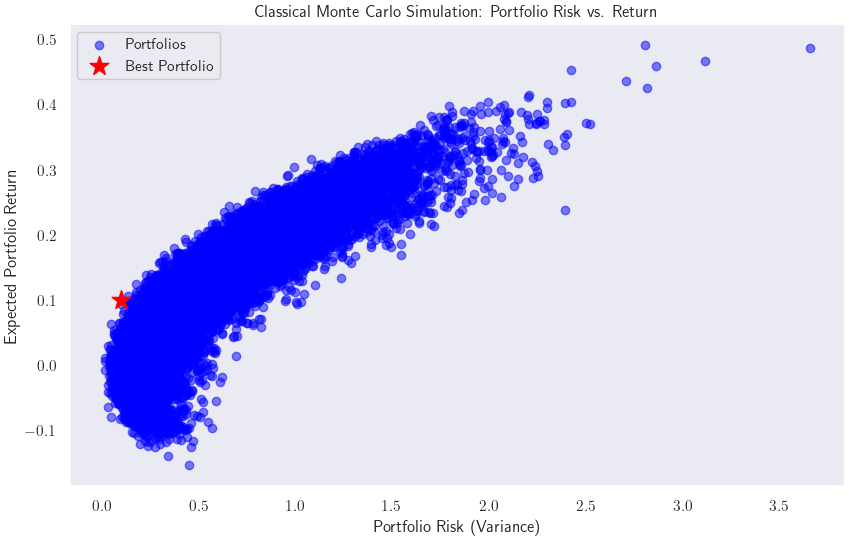

In [56]:
# Plotting the results
import seaborn as sns
import scienceplots

plt.style.use(['science', 'grid'])

sns.set()

plt.figure(figsize=(10, 6))
plt.scatter(risks_list, returns_list, alpha=0.5, color='blue', label='Portfolios')
plt.scatter(np.dot(best_portfolio.T, np.dot(covariance, best_portfolio)), np.dot(ev, best_portfolio), 
            color='red', marker='*', s=200, label='Best Portfolio')
plt.title('Classical Monte Carlo Simulation: Portfolio Risk vs. Return')
plt.xlabel('Portfolio Risk (Variance)')
plt.ylabel('Expected Portfolio Return')
plt.legend()
plt.grid()
plt.show()

### Gradient Comparison and Analysis

In [49]:
grad_finite = FiniteDiffEstimatorGradient(estimator, epsilon=0.001)
grad_SPSA = SPSAEstimatorGradient(estimator, epsilon=0.001, batch_size=10, seed=50)
qgt = LinCombQGT(estimator, derivative_type=DerivativeType.COMPLEX)
grad_pshift = ParamShiftEstimatorGradient(estimator)

# Replace deprecated Sampler with StatevectorSampler
pshift_sampler = ParamShiftSamplerGradient(StatevectorSampler())
grad_natural = QFI(qgt)

In [50]:
def gd(init_params, p, iterations, H, step):
    params = [[init_params], [init_params], [init_params], [init_params]]
    qc = EfficientSU2(num_qubits=4, reps=p, entanglement="linear", insert_barriers = True)
    for i in range(iterations):
        grad_finite_res = grad_finite.run([qc], [H], [params[0][i]]).result().gradients[0]
        params[0].append(params[0][i] - step * grad_finite_res)
        
        grad_spsa_res = grad_SPSA.run([qc], [H], [params[1][i]]).result().gradients[0]
        params[1].append(params[1][i] - step * grad_spsa_res)
        
        qfis = grad_natural.run([qc], [params[2][i]]).result().qfis[0]
        tmp_grad = grad_finite.run([qc], [H], [params[2][i]]).result().gradients[0]
        params[2].append(params[2][i] - step * np.dot(np.linalg.pinv(qfis), tmp_grad))

        grad_pshift_res = grad_pshift.run([qc], [H], [params[3][i]]).result().gradients[0]
        params[3].append(params[3][i] - step * grad_pshift_res)
        
        #step = step * .75 # Modification to decay the step distance 
    return params

### Entanglement Schemes Comparison and Analysis